## Import libraries

In [1]:
import sys, os
sys.path.append(os.path.abspath('../src'))

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import train


In [2]:
# Import personalized modules
from train import (
    build_dense_model, build_rnn_model, build_lstm_model,
    train_model, grid_search_dense, bayes_opt_rnn, bayes_opt_lstm
)
from evaluate import evaluate_model
from visualize import (
    plot_training_history, plot_confusion_matrix,
    plot_roc_curve, plot_precision_recall, compare_training_histories, compare_metrics
)

## Load needed data

In [5]:
print("Load preprocessed dataset...")
df = pd.read_csv("../data/processed/clean_reviews.csv")
print(f"Dataset loaded: {df.shape}")
print(df.head())

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_sentence"], df["label"],
    test_size=0.2, random_state=42
)

Load preprocessed dataset...
Dataset loaded: (2727, 2)
                                      clean_sentence  label
0        aimless movie distressed drifting young man      0
1  sure lost flat character audience nearly half ...      0
2  attempting artiness black white clever camera ...      0
3                        little music anything speak      0
4  best scene movie gerardo trying find song keep...      1


In [6]:
# --- Dense NN with TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()
input_dim = X_train_tfidf.shape[1]

# --- RNN / LSTM with sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)
vocab_size = len(tokenizer.word_index) + 1

## 1. Dense neural network


Training dense model (default parameters)...

Epoch 1/10


55/55 [==============================] - 3s 15ms/step - loss: 0.6880 - accuracy: 0.5791 - val_loss: 0.6712 - val_accuracy: 0.7529
Epoch 2/10
55/55 [==============================] - 0s 7ms/step - loss: 0.5615 - accuracy: 0.8733 - val_loss: 0.4972 - val_accuracy: 0.8032
Epoch 3/10
55/55 [==============================] - 0s 7ms/step - loss: 0.2729 - accuracy: 0.9226 - val_loss: 0.4243 - val_accuracy: 0.8009
Epoch 4/10
55/55 [==============================] - 0s 7ms/step - loss: 0.1289 - accuracy: 0.9656 - val_loss: 0.4441 - val_accuracy: 0.7986
Epoch 5/10
55/55 [==============================] - 0s 7ms/step - loss: 0.0770 - accuracy: 0.9805 - val_loss: 0.4793 - val_accuracy: 0.7918
Epoch 6/10
55/55 [==============================] - 0s 7ms/step - loss: 0.0498 - accuracy: 0.9868 - val_loss: 0.5131 - val_accuracy: 0.7918
Epoch 7/10
55/55 [==============================] - 0s 7ms/step - loss: 0.0383 - accuracy: 0.9897 - val_loss: 

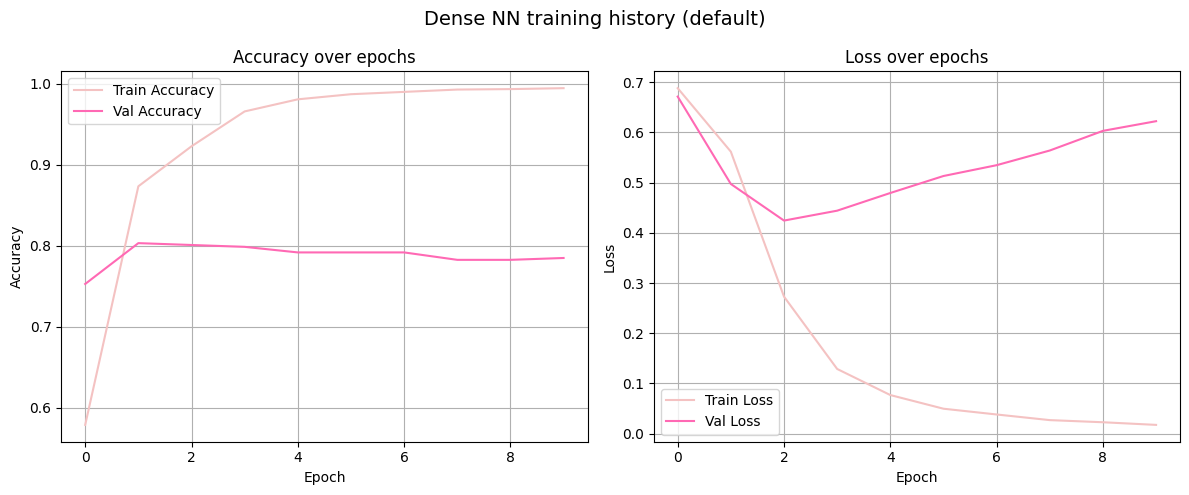

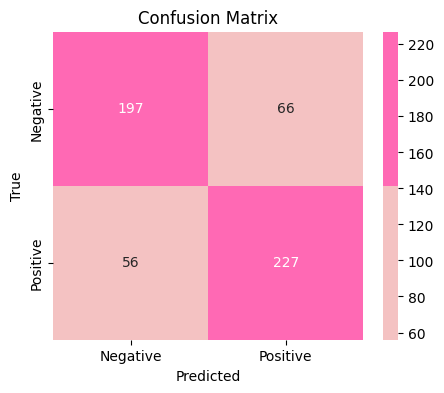

18/18 [==============================] - 0s 4ms/step


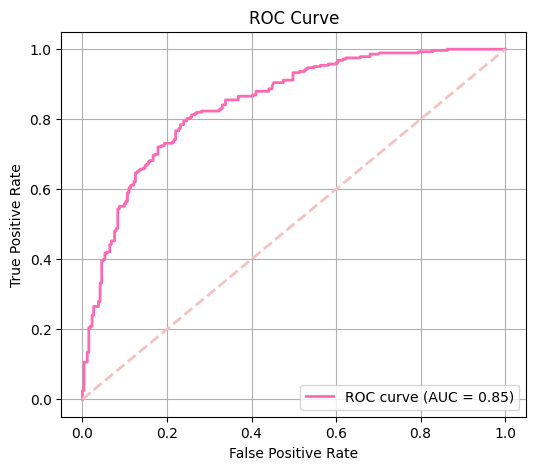

18/18 [==============================] - 0s 3ms/step


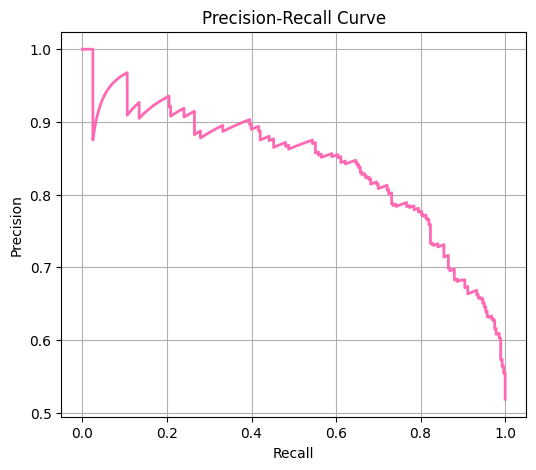

In [10]:
# Training without optimization
print("\nTraining dense model (default parameters)...")
dense_default = build_dense_model(input_dim)
history_default = dense_default.fit(
    X_train_tfidf, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Evaluation
dense_default_results = evaluate_model(dense_default, X_test_tfidf, y_test)
y_pred_default = (dense_default.predict(X_test_tfidf) > 0.5).astype(int)

# Plots
plot_training_history(history_default, "Dense NN training history (default)")
plot_confusion_matrix(y_test, y_pred_default)
plot_roc_curve(y_test, dense_default.predict(X_test_tfidf))
plot_precision_recall(y_test, dense_default.predict(X_test_tfidf))


Training dense model (grid search)...

Training Dense(64) | lr=0.001 | batch=32 | epochs=5
Epoch 1/5
69/69 [==============================] - 2s 10ms/step - loss: 0.6831 - accuracy: 0.6071 - val_loss: 0.6505 - val_accuracy: 0.7821
Epoch 2/5
69/69 [==============================] - 0s 7ms/step - loss: 0.4977 - accuracy: 0.8817 - val_loss: 0.4645 - val_accuracy: 0.8004
Epoch 3/5
69/69 [==============================] - 0s 7ms/step - loss: 0.2292 - accuracy: 0.9253 - val_loss: 0.4748 - val_accuracy: 0.7930
Epoch 4/5
69/69 [==============================] - 1s 8ms/step - loss: 0.1179 - accuracy: 0.9688 - val_loss: 0.5253 - val_accuracy: 0.7912
Epoch 5/5
69/69 [==============================] - 0s 7ms/step - loss: 0.0728 - accuracy: 0.9803 - val_loss: 0.5914 - val_accuracy: 0.7894
Val Accuracy: 0.7894

Training Dense(64) | lr=0.001 | batch=64 | epochs=5
Epoch 1/5
35/35 [==============================] - 2s 16ms/step - loss: 0.6892 - accuracy: 0.5378 - val_loss: 0.6785 - val_accuracy: 0.617

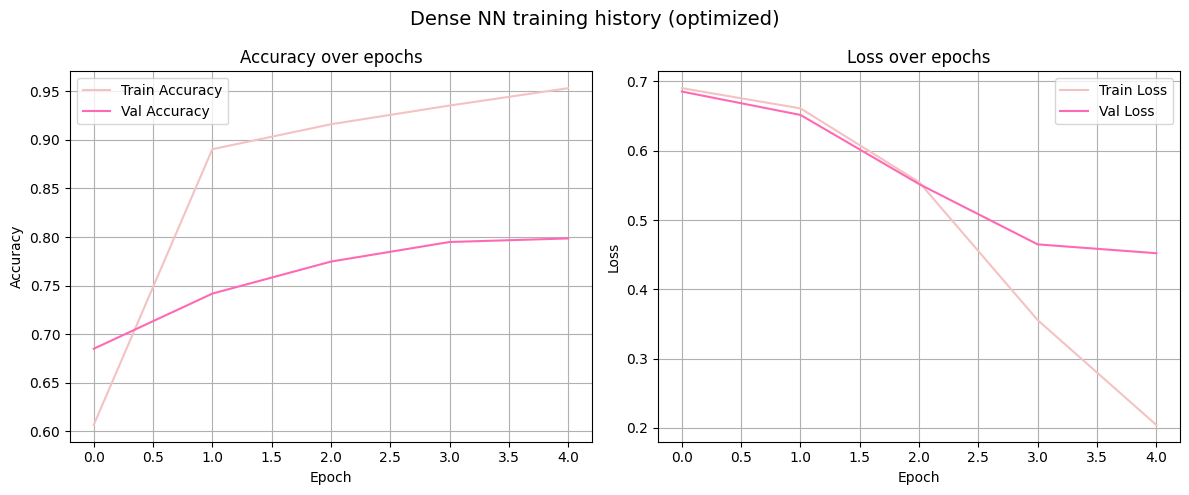

18/18 [==============================] - 0s 3ms/step
=== Evaluation Metrics ===
Accuracy : 0.7985
Precision: 0.8145
Recall   : 0.7915
F1-score : 0.8029
Cohen’s Kappa: 0.5970

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79       263
           1       0.81      0.79      0.80       283

    accuracy                           0.80       546
   macro avg       0.80      0.80      0.80       546
weighted avg       0.80      0.80      0.80       546

18/18 [==============================] - 0s 3ms/step


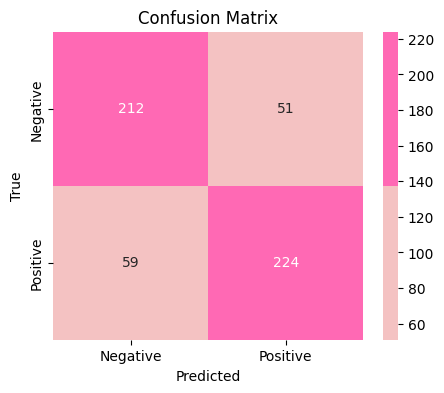

18/18 [==============================] - 0s 4ms/step


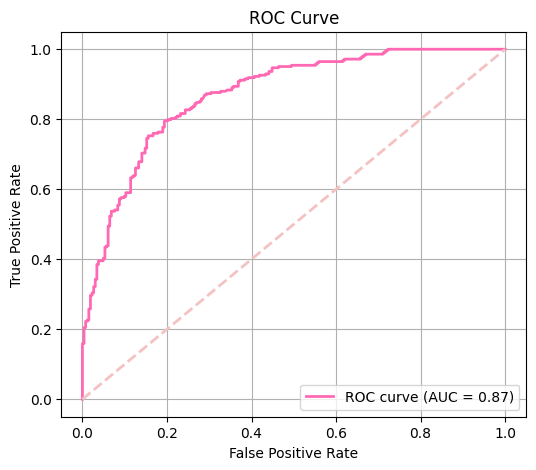

18/18 [==============================] - 0s 3ms/step


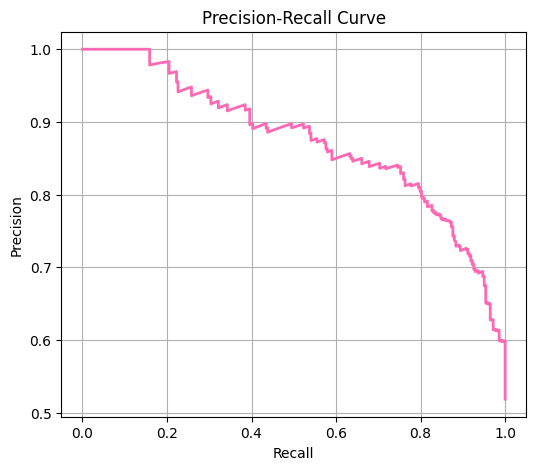

In [12]:
print("\nTraining dense model (grid search)...")
best_dense, best_history, best_params, best_score = grid_search_dense(
    X_train_tfidf, y_train, X_test_tfidf, y_test, input_dim
)

print(f"Best dense configuration: {best_params}")
plot_training_history(best_dense.history, "Dense NN training history (optimized)")

dense_results = evaluate_model(best_dense, X_test_tfidf, y_test)
y_pred_dense = (best_dense.predict(X_test_tfidf) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_dense)
plot_roc_curve(y_test, best_dense.predict(X_test_tfidf))
plot_precision_recall(y_test, best_dense.predict(X_test_tfidf))

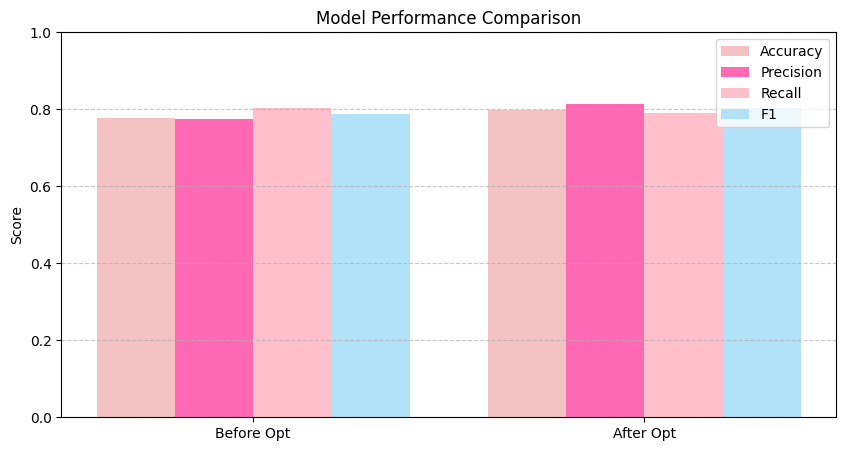

In [ ]:
# Comparison of final metrics
results = {
    "Before Opt": dense_default_results,
    "After Opt": dense_results
}
compare_metrics(results)


## 2. Vanilla RNN


 Training RNN model without optimization...

Epoch 1/5


69/69 [==============================] - 5s 34ms/step - loss: 0.6728 - accuracy: 0.5878 - val_loss: 0.6161 - val_accuracy: 0.7070
Epoch 2/5
69/69 [==============================] - 2s 29ms/step - loss: 0.4306 - accuracy: 0.8657 - val_loss: 0.5629 - val_accuracy: 0.7308
Epoch 3/5
69/69 [==============================] - 2s 27ms/step - loss: 0.1689 - accuracy: 0.9569 - val_loss: 0.5438 - val_accuracy: 0.7363
Epoch 4/5
69/69 [==============================] - 2s 29ms/step - loss: 0.0758 - accuracy: 0.9789 - val_loss: 0.6278 - val_accuracy: 0.7271
Epoch 5/5
69/69 [==============================] - 2s 28ms/step - loss: 0.1311 - accuracy: 0.9541 - val_loss: 0.7052 - val_accuracy: 0.6722

Base RNN model results:


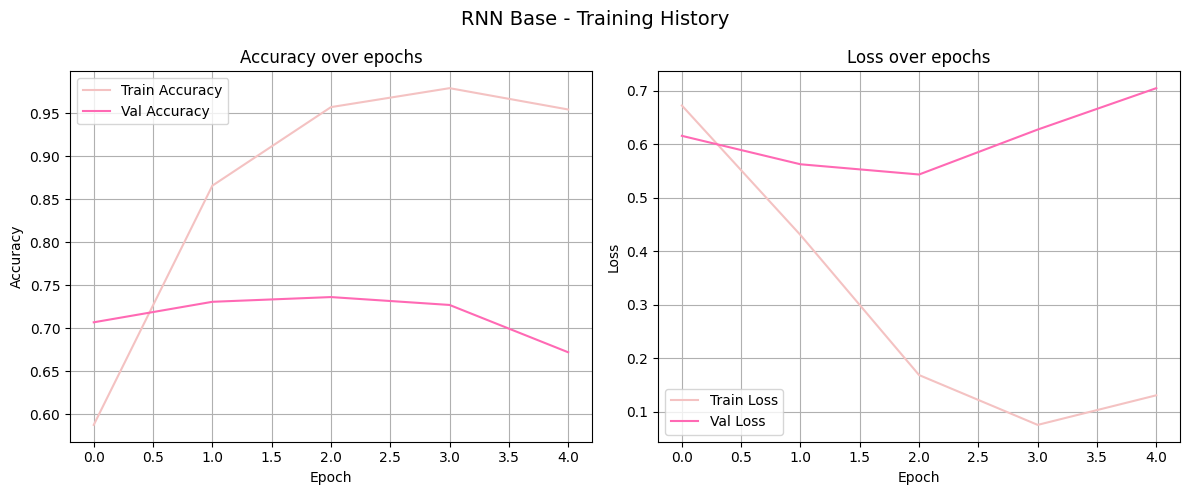

18/18 [==============================] - 0s 8ms/step
=== Evaluation Metrics ===
Accuracy : 0.6722
Precision: 0.6576
Recall   : 0.7668
F1-score : 0.7080
Cohen’s Kappa: 0.3393

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.57      0.63       263
           1       0.66      0.77      0.71       283

    accuracy                           0.67       546
   macro avg       0.68      0.67      0.67       546
weighted avg       0.68      0.67      0.67       546

18/18 [==============================] - 0s 7ms/step


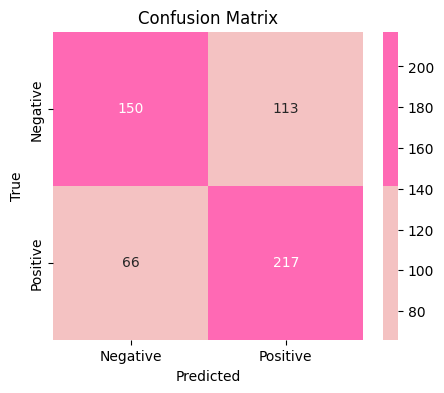

18/18 [==============================] - 0s 8ms/step


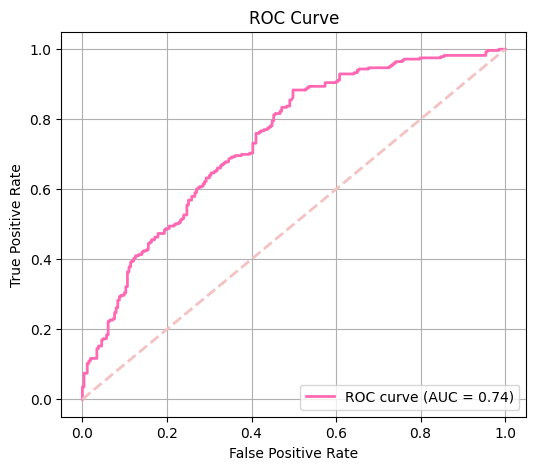

18/18 [==============================] - 0s 9ms/step


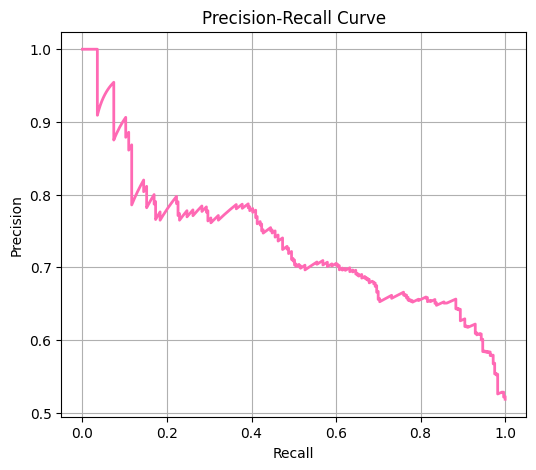

In [5]:
# Vanilla RNN without optimization
print("\n Training RNN model without optimization...")
rnn_model = build_rnn_model(vocab_size)

rnn_model, history_rnn, _ = train_model(
    rnn_model,
    X_train_pad, y_train,
    X_test_pad,  y_test,
    epochs=5,
    batch_size=32
)

print("\nBase RNN model results:")
plot_training_history(history_rnn, "RNN Base - Training History")

rnn_results = evaluate_model(rnn_model, X_test_pad, y_test)

y_pred_rnn = (rnn_model.predict(X_test_pad) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_rnn)
plot_roc_curve(y_test, rnn_model.predict(X_test_pad))
plot_precision_recall(y_test, rnn_model.predict(X_test_pad))



Starting Bayesian Optimization (EI) for RNN...

 Testing RNN: emb=259, units=99, lr=0.002112, batch=89
Epoch 1/10
25/25 [==============================] - 5s 83ms/step - loss: 0.6683 - accuracy: 0.5759 - val_loss: 0.6057 - val_accuracy: 0.6667
Epoch 2/10
25/25 [==============================] - 2s 62ms/step - loss: 0.2804 - accuracy: 0.9243 - val_loss: 0.5598 - val_accuracy: 0.7289
Epoch 3/10
25/25 [==============================] - 2s 61ms/step - loss: 0.2771 - accuracy: 0.8707 - val_loss: 0.8361 - val_accuracy: 0.6722
Epoch 4/10
25/25 [==============================] - 2s 62ms/step - loss: 0.1111 - accuracy: 0.9606 - val_loss: 0.7070 - val_accuracy: 0.7143
Epoch 5/10
25/25 [==============================] - 2s 65ms/step - loss: 0.0508 - accuracy: 0.9830 - val_loss: 0.8109 - val_accuracy: 0.7015
Epoch 6/10
25/25 [==============================] - 2s 65ms/step - loss: 0.0279 - accuracy: 0.9913 - val_loss: 0.8631 - val_accuracy: 0.7161
Epoch 7/10
25/25 [==============================]

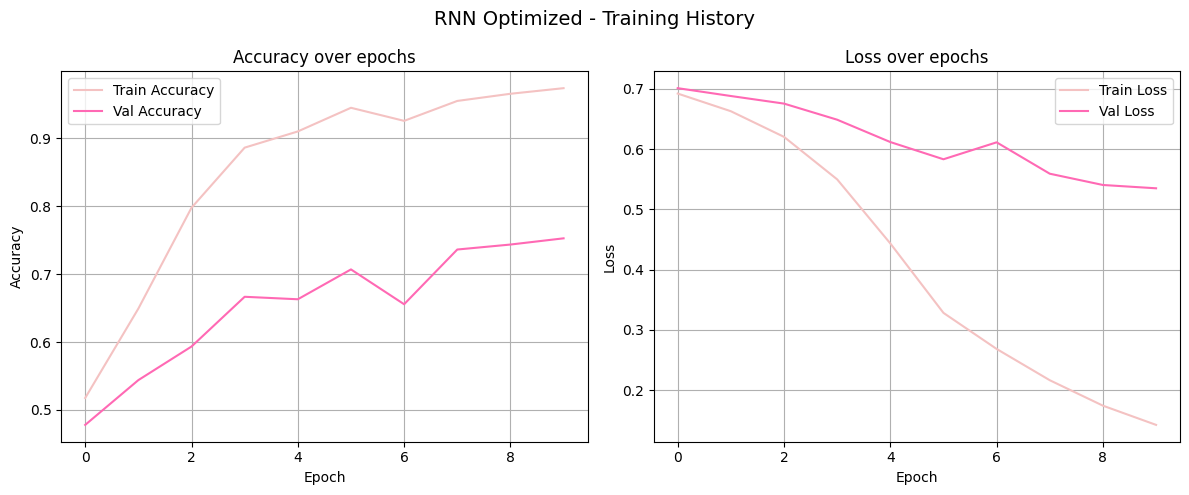

18/18 [==============================] - 0s 9ms/step
=== Evaluation Metrics ===
Accuracy : 0.7527
Precision: 0.7681
Recall   : 0.7491
F1-score : 0.7585
Cohen’s Kappa: 0.5053

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.76      0.75       263
           1       0.77      0.75      0.76       283

    accuracy                           0.75       546
   macro avg       0.75      0.75      0.75       546
weighted avg       0.75      0.75      0.75       546

18/18 [==============================] - 0s 11ms/step


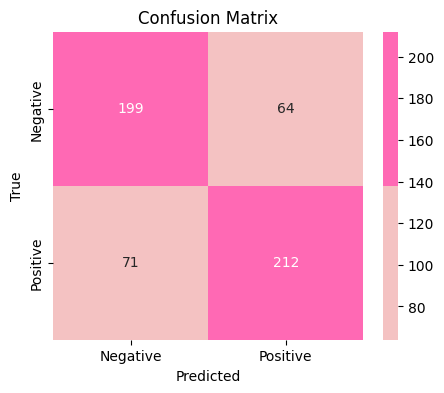

18/18 [==============================] - 0s 9ms/step


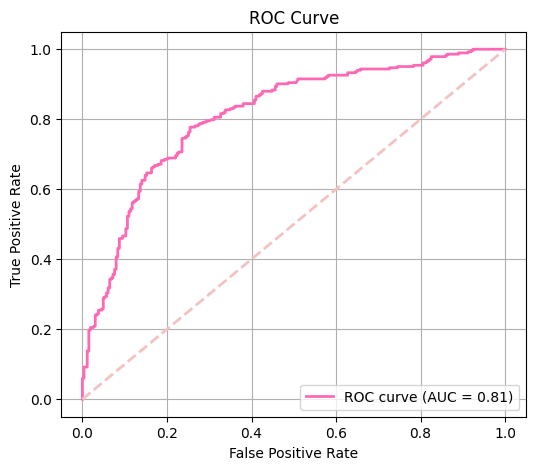

18/18 [==============================] - 0s 9ms/step


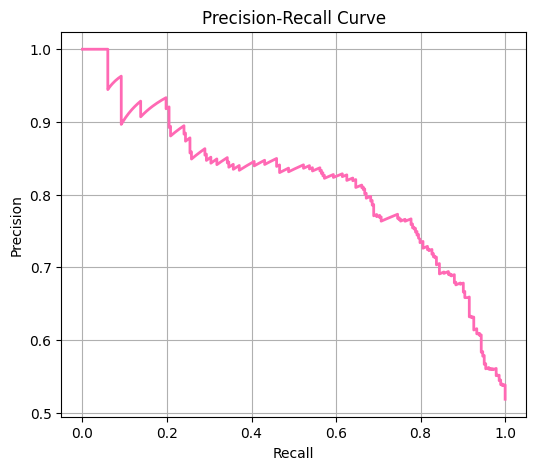

In [6]:
#   Phase 2: Training with EI optimization
print("\n\nStarting Bayesian Optimization (EI) for RNN...")

best_rnn_model, best_rnn_history, best_rnn_params, best_rnn_score = bayes_opt_rnn(
    X_train_pad, y_train,
    X_test_pad,  y_test,
    vocab_size=vocab_size
)

print("\nBest RNN model found (Bayesian Optimization):")
print(best_rnn_params)
print(f"Best Validation Accuracy: {best_rnn_score:.4f}")

# Results of the optimized model
print("\nOptimized RNN model results:")
plot_training_history(best_rnn_history, "RNN Optimized - Training History")

rnn_opt_results = evaluate_model(best_rnn_model, X_test_pad, y_test)

y_pred_rnn_opt = (best_rnn_model.predict(X_test_pad) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_rnn_opt)
plot_roc_curve(y_test, best_rnn_model.predict(X_test_pad))
plot_precision_recall(y_test, best_rnn_model.predict(X_test_pad))

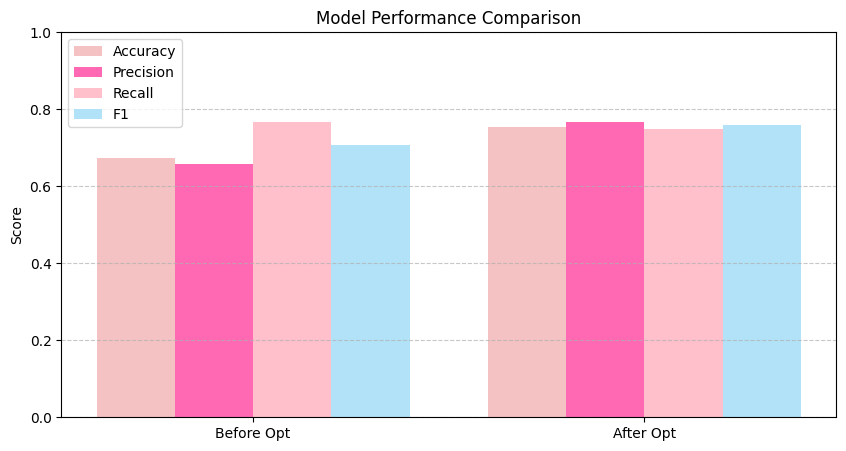

In [7]:
# Comparison of final metrics
results = {
    "Before Opt": rnn_results,
    "After Opt": rnn_opt_results
}
compare_metrics(results)

## 3. LSTM


 Training LSTM baseline model...

Epoch 1/5


69/69 [==============================] - 10s 80ms/step - loss: 0.6742 - accuracy: 0.5979 - val_loss: 0.6265 - val_accuracy: 0.6374
Epoch 2/5
69/69 [==============================] - 4s 64ms/step - loss: 0.4040 - accuracy: 0.8372 - val_loss: 0.4585 - val_accuracy: 0.7949
Epoch 3/5
69/69 [==============================] - 4s 63ms/step - loss: 0.2932 - accuracy: 0.9161 - val_loss: 0.4719 - val_accuracy: 0.7875
Epoch 4/5
69/69 [==============================] - 5s 67ms/step - loss: 0.2071 - accuracy: 0.9349 - val_loss: 0.5021 - val_accuracy: 0.7857
Epoch 5/5
69/69 [==============================] - 4s 64ms/step - loss: 0.1125 - accuracy: 0.9693 - val_loss: 0.5581 - val_accuracy: 0.7729

Evaluating baseline model...
18/18 [==============================] - 1s 20ms/step
=== Evaluation Metrics ===
Accuracy : 0.7729
Precision: 0.7849
Recall   : 0.7739
F1-score : 0.7794
Cohen’s Kappa: 0.5454

Classification Report:
               precision    recal

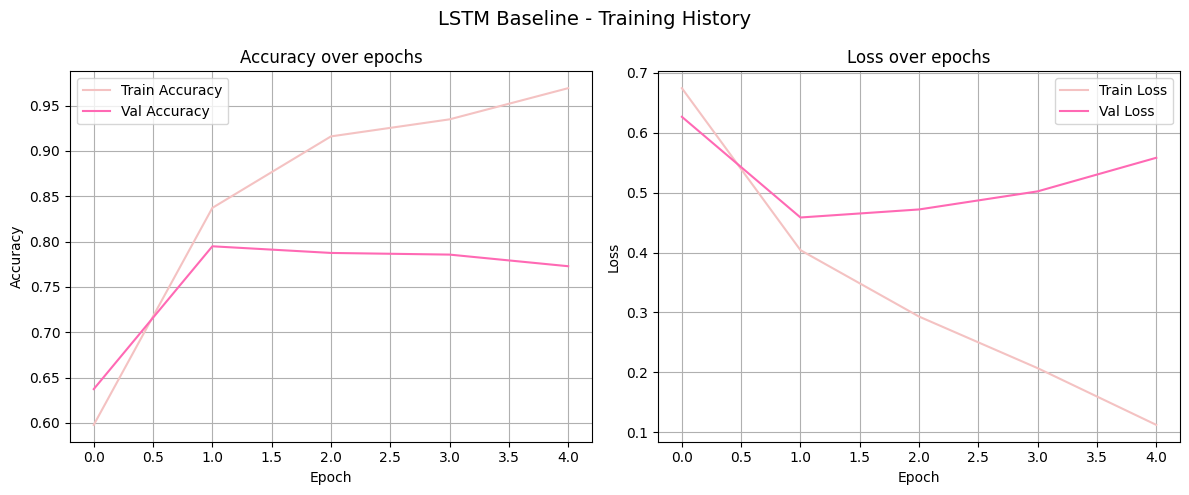

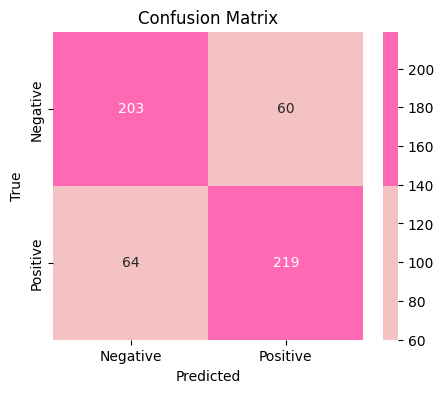

18/18 [==============================] - 0s 22ms/step


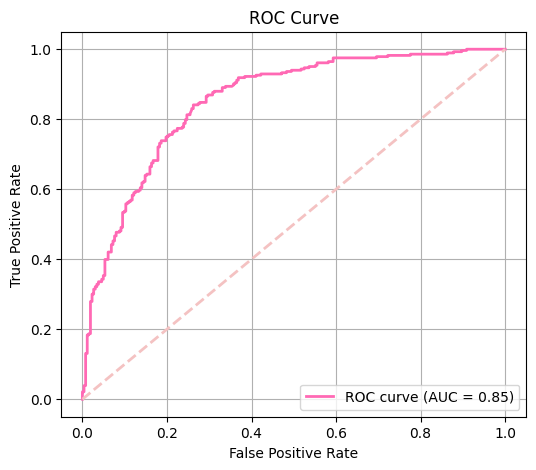

18/18 [==============================] - 0s 19ms/step


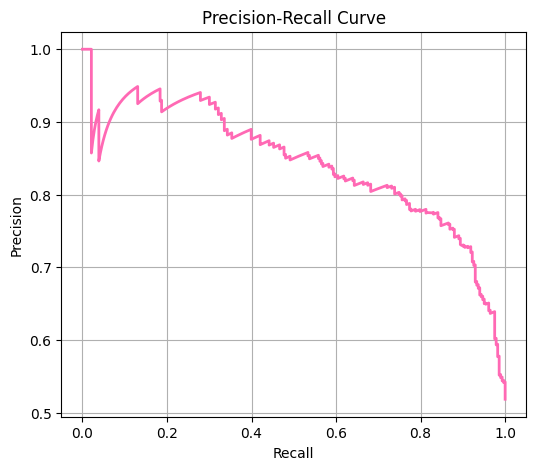

In [7]:
# 1. LSTM without optimization
print("\n Training LSTM baseline model...")
lstm_baseline = build_lstm_model(vocab_size)

lstm_baseline, history_lstm_base, _ = train_model(
    lstm_baseline,
    X_train_pad, y_train,
    X_test_pad, y_test,
    epochs=5,
    batch_size=32
)

print("\nEvaluating baseline model...")
lstm_results = evaluate_model(lstm_baseline, X_test_pad, y_test)

# Baseline predictions
y_pred_lstm_base = (lstm_baseline.predict(X_test_pad) > 0.5).astype(int)

# Baseline plots
plot_training_history(history_lstm_base, "LSTM Baseline - Training History")
plot_confusion_matrix(y_test, y_pred_lstm_base)
plot_roc_curve(y_test, lstm_baseline.predict(X_test_pad))
plot_precision_recall(y_test, lstm_baseline.predict(X_test_pad))

In [8]:
#   Phase 2: Training with EI optimization
print("\n\nStarting Bayesian Optimization (EI) for LSTM...")

best_lstm_model, best_lstm_history, best_lstm_params, best_lstm_score = bayes_opt_lstm(
    X_train_pad, y_train,
    X_test_pad,  y_test,
    vocab_size=vocab_size
)

print("\nBest LSTM model found (Bayesian Optimization):")
print(best_lstm_params)
print(f"Best Validation Accuracy: {best_lstm_score:.4f}")

# Results of the optimized model
print("\nOptimized LSTM model results:")
plot_training_history(best_lstm_history, "LSTM Optimized - Training History")

lstm_opt_results = evaluate_model(best_lstm_model, X_test_pad, y_test)

y_pred_lstm_opt = (best_lstm_model.predict(X_test_pad) > 0.5).astype(int)
plot_confusion_matrix(y_test, y_pred_lstm_opt)
plot_roc_curve(y_test, best_lstm_model.predict(X_test_pad))
plot_precision_recall(y_test, best_lstm_model.predict(X_test_pad))



Starting Bayesian Optimization (EI) for LSTM...

 Testing LSTM: emb=259, units=99, lr=0.002112, batch=89
Epoch 1/10
25/25 [==============================] - 10s 243ms/step - loss: 0.6645 - accuracy: 0.6043 - val_loss: 0.5621 - val_accuracy: 0.7564
Epoch 2/10
25/25 [==============================] - 5s 203ms/step - loss: 0.3695 - accuracy: 0.8657 - val_loss: 0.4871 - val_accuracy: 0.7747
Epoch 3/10
25/25 [==============================] - 5s 189ms/step - loss: 0.2176 - accuracy: 0.9262 - val_loss: 0.5763 - val_accuracy: 0.7509
Epoch 4/10
25/25 [==============================] - 5s 187ms/step - loss: 0.1558 - accuracy: 0.9500 - val_loss: 0.6610 - val_accuracy: 0.7527
Epoch 5/10
25/25 [==============================] - 5s 196ms/step - loss: 0.0969 - accuracy: 0.9716 - val_loss: 0.7477 - val_accuracy: 0.7454
Epoch 6/10
25/25 [==============================] - 5s 195ms/step - loss: 0.0661 - accuracy: 0.9807 - val_loss: 0.8708 - val_accuracy: 0.7436
Epoch 7/10
25/25 [======================

IndexError: list index out of range

In [ ]:
# Comparison of final metrics
results = {
    "Before Opt": lstm_results,
    "After Opt": lstm_opt_results
}
compare_metrics(results)



 Comparando resultados...


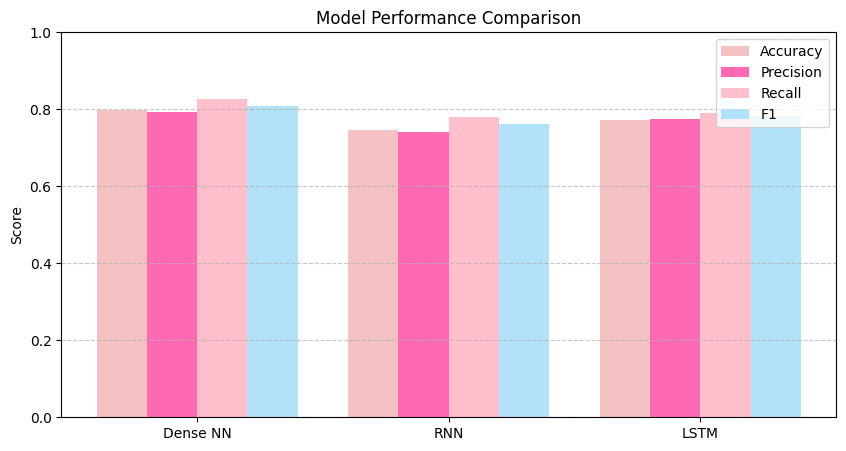

 Entrenamiento y evaluación completados.


In [ ]:
# Comparación final de modelos
print("\n Comparando resultados...")
results_dict = {
    "Dense NN": dense_results,
    "RNN": rnn_results,
    "LSTM": lstm_results
}

compare_metrics(results_dict)
print(" Entrenamiento y evaluación completados.")
